In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2021 gq <gq@gqhp>
#
# Distributed under terms of the MIT license.

"""
test DAC sampling
"""
%matplotlib widget

import socket
import numpy as np

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

# src_udp_ip = "192.168.90.20"
# src_udp_ip = "127.0.0.1"
# src_udp_port = 59000


udp_ip = "192.168.90.100"
udp_port = 60000

# udp_ip = "127.0.0.1"
# udp_port = 50001

sock = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.bind((udp_ip, udp_port))
# sock.setsockopt(socket.SO_NO_CHECK,1)


# sock.setsockopt(socket.IPPROTO_UDP, 1, 1)

# sock.connect((src_udp_ip, src_udp_port))
# data, addr=sock.recvfrom(8000)

packet_size = 8192
size = 8200

udp_data = sock.recv(size)
udp_data = memoryview(udp_data)

print("get data")

chunk = np.frombuffer(udp_data[0:packet_size], dtype='>i2')

print("id: ", int.from_bytes(udp_data[8196:8200], 'big'))
print("max integer: ", chunk.max(), chunk.min())

scale_f = 0.5/ (2 ** 15)
real_data = chunk *  scale_f

sample_rate = 819200 #Mhz
timestep = 1.0/sample_rate

k = 2.23
beta = 16.7
       
kasier_fil = np.kaiser(packet_size//2, beta)
factor_kasier = np.sum(kasier_fil)

# fft_size = packet_size/2
# fft_data = rfft(real_data*kasier_fil)
fft_data = rfft(real_data)
freq = rfftfreq(packet_size//2, d=timestep)

# logdata = np.log10(np.abs(fft_data/(packet_size/2))**2)
logdata = np.abs(fft_data/(packet_size/2))**2

unit = 'dBm'


def fft_to_dBV(data):
    
    out = 20.*np.log10(np.abs(data/data.size))
    return out

def fft_to_dBm(data):
    
    out = 10.*np.log10(np.abs(data/data.size)**2/50/0.001)
    return out

if unit == 'dBm':
    print("unit is dBm")
    # should I remove factor_kasier
    # add factor=2 because the power of AC singals is 1/2
    # 
    # dbm_fft_data = 10*np.log10(np.abs(fft_data/fft_size/factor_kasier)**2/(1e-3)/50.0)
    dbm_fft_data = fft_to_dBm(fft_data)
    
# if unit == 'dBV':
#     print("unit is dBm")
#     # should I remove factor_kasier
#     # add factor=2 because the power of AC singals is 1/2
#     # 
#     dbm_fft_data = fft_to_dBV(fft_data)
    
sock.close()
# plt.plot(freq, logdata)
plt.figure()
plt.plot(np.arange(real_data.size), real_data, lw = 0.5)
# plt.plot(np.arange(real_data.size), real_data, 'o', ms=1.0)
plt.xlabel("Sequence")
plt.ylabel("Voltage")
# plt.ylim([0.0475,0.0650])
plt.show()

plt.figure()
plt.xlabel("Freq")
unit='dog'
if unit == 'dBm':
    plt.ylabel(unit)
    print("max dbm: ", dbm_fft_data.max())
    plt.plot(freq, dbm_fft_data)
else:
    plt.ylabel("Power spectrum")
    plt.plot(freq, logdata)
plt.show()

In [ ]:
redata = real_data
redata[748],redata[749] =redata[749], redata[748]
plt.figure()
plt.plot(np.arange(real_data.size), redata, lw = 0.5)
plt.plot(np.arange(real_data.size), redata, 'o', ms=1.0)
plt.xlim([720, 780])
plt.ylim([0.048, 0.062])
plt.show()


# Test direct FFT result output
----

SRC MAC: 

SRC IP: 192.168.90.21

SRC port 59001

DST MAC: 00:1b:21:85:6e:a1

DST IP: 192.168.90.100

SRC port 6001

---



id_out now 12
446848
446849
446850
446851
446852
446853
446854
446855
446856
446857
446858
446859
446860
446861
446862
446863
get data
data point 32768 3762293581


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
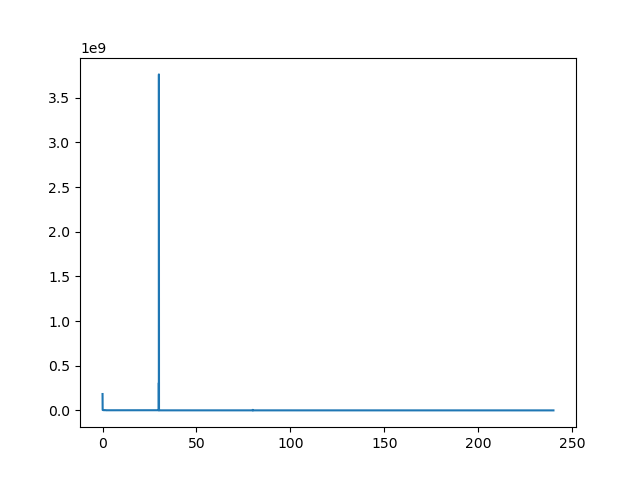

In [13]:
%matplotlib widget

import socket
import numpy as np

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

src_udp_ip = "192.168.90.21"
src_udp_port = 59001


udp_ip = "192.168.90.100"
udp_port = 60001

# udp_ip = "127.0.0.1"
# udp_port = 60002

sock = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.bind((udp_ip, udp_port))
# sock.setsockopt(socket.SO_NO_CHECK,1)

# sample_rate = 8192 * 8
sample_rate = 480

# sock.setsockopt(socket.IPPROTO_UDP, 1, 1)

# sock.connect((src_udp_ip, src_udp_port))
# data, addr=sock.recvfrom(8000)

payload_size = 8200
data_size = 8192
id_size = 4

count = 16

udp_payload = bytearray(count*payload_size)
udp_data = bytearray(count*data_size)
udp_id = bytearray(count*id_size)

data_buff = memoryview(udp_data)
payload_buff = memoryview(udp_payload)
id_buff = memoryview(udp_id)

pi1 = 0
pi2 = data_size

hi1 = 0
hi2 = id_size

id_out = 0

while id_out % count != count-1:
    sock.recv_into(payload_buff, payload_size)
    id_out = int.from_bytes(payload_buff[payload_size - id_size:payload_size], 'big')

print('id_out now', id_out%15)

while count:
    sock.recv_into(payload_buff, payload_size)
    data_buff[pi1:pi2] = payload_buff[0:data_size]
    id_buff[hi1:hi2] = payload_buff[payload_size - id_size:payload_size] 
    pi1 += data_size
    pi2 += data_size
    hi1 += id_size
    hi2 += id_size
    
    id_out = int.from_bytes(payload_buff[payload_size - id_size:payload_size], 'big')
    print(id_out)
    
    count -= 1

print("get data")
sock.close()

chunk = np.frombuffer(udp_data, dtype='>u4')
tot_size = chunk.size
print("data point", chunk.size, chunk.max())
plt.plot(np.arange(chunk.size)/tot_size*sample_rate/2., chunk)
#plt.yscale('log')
plt.show()

# Decode GPS/NTP informatoin

In [11]:
import socket
from io import BytesIO
import pynmea2
from pynmea2 import ParseError
import sys

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(("192.168.1.111", 4001))

print("Connecting to the GPS/Oscillator system....\n")

lat_showed = False
lon_showed = False
sat_num_showed = False
ant_showed = False
sat_showed = False
system_ready = False

with BytesIO() as buffer:
    while not system_ready:
        ff = s.recv(2048)       # Read in some number of bytes -- balance this
        buffer.write(ff)
        buffer.seek(0)
        for line in buffer.readlines():
            if line == '':
                break

            try:
                msg = pynmea2.parse(line.decode())
            except ParseError:
                pass
            else:
                if hasattr(msg, "lat") and not lat_showed:
                    lat = msg.lat
                    # lmin = msg[3:]
                    full_lat = msg.lat_dir + lat[0:2]+ u"\N{DEGREE SIGN}" + lat[2:] + "'"

                    lon = msg.lon
                    # lmin = msg[3:]
                    full_lon = msg.lon_dir + lon[0:3]+ u"\N{DEGREE SIGN}" + lon[3:] + "'"
                    print("Latitude: ", full_lon, "Latitude: ", full_lat)

                    lat_showed = True
                    lon_showed = True


                if hasattr(msg, 'data'):
                    if hasattr(msg, 'msg_type') and msg.msg_type == '12':
                        print("Date: ", msg.data[3] + '.' + msg.data[2] +'.' + msg.data[1], msg.data[0])
                        print("GPS Sat number: ", msg.data[4], ", BD Sat number :", msg.data[5])
                        sat_showed = True


                    if "WARMUP" in msg.data:
                        print("Oscillator is warmed up")

                    if "ACQUIRING" in msg.data:
                        print("Oscillator is acquiring")

                    if "HOLDOVER" in msg.data:
                        print("Oscillator is in state of holdover...........WARNING, will FAILED in 24 hours")

                    if "ANTENNA OPEN" in msg.data:
                        print("ANTENNA is disconnected.......FAILED")

                    if "ANTENNA SHORT" in msg.data:
                        print("ANTENNA is shorted.......FAILED")

                    if "ANTENNA OK" in msg.data and not ant_showed:
                        print("ANTENNA is ready.......OK")
                        ant_showed = True

                    if "LOCKED" in msg.data:
                        print("Oscillator is locked..........OK")

                    if ant_showed:
                        print("GPS Timer and Oscillator is ready ...... OK\n")
                        print("Exited.....\n")
                        system_ready=True

s.close()

Connecting to the GPS/Oscillator system....

Latitude:  E121°25.7741' Latitude:  N31°11.4166'
Date:  2021.12.22 230645.00
GPS Sat number:  12 , BD Sat number : 16
ANTENNA is ready.......OK
Oscillator is locked..........OK
GPS Timer and Oscillator is ready ...... OK

Exited.....



In [ ]:
msg = pynmea2.parse('$GNTXT,224831.00,22,12,2021,12,18,-115,25462,LOCKED,ANTENNA OK*27\r\n')
msg

In [ ]:
msg.msg_type

In [ ]:
hasattr(msg, 'dog')

In [ ]:
xdata = data.decode("ascii")

In [ ]:
data.decode().rstrip()

In [ ]:
x='$GPGSV,4,2,13,01,59,178,17,08,46,036,35,30,42,300,,14,16,307,22,0*6D'
y='$GNTXT,202930.00,22,12,2021,13,18,15,25400,LOCKED,ANTENNA OK*3A\r'
msg = pynmea2.parse(x)
msg

In [ ]:
from io import StringIO
x = bx.decode()

f = StringIO(x)
while True:
    s=f.readline()
    if s == '':
        break
    print(s.strip())

In [ ]:
import socket
import time
from io import BytesIO

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(('192.168.1.111', 4001))
sock.setblocking(False)


def handle_line(line):
    # or, print("Line Received:", line.decode().rstrip())
    print("Line Received:", line.decode())

def delimited(file, delimiter='\n', bufsize=4096):
    buf = ''
    while True:
        newbuf = file.read(bufsize)
        if not newbuf:
            yield buf
            return
        buf += newbuf
        lines = buf.split(delimiter)
        for line in lines[:-1]:
            yield line
        buf = lines[-1]
        
with BytesIO() as buffer:
    while True:
        try:
            resp = sock.recv(100)       # Read in some number of bytes -- balance this
        except BlockingIOError:
            print("sleeping")           # Do whatever you want here, this just
            time.sleep(2)               #   illustrates that it's nonblocking
        else:
            buffer.write(resp)          # Write to the BytesIO object
            buffer.seek(0)              # Set the file pointer to the SoF
            start_index = 0             # Count the number of characters processed
            nb = delimited(buffer, '\n')
            for line in nb:
                start_index += len(line)
                handle_line(line)       # Do something with your line

            """ If we received any newline-terminated lines, this will be nonzero.
                In that case, we read the remaining bytes into memory, truncate
                the BytesIO object, reset the file pointer and re-write the
                remaining bytes back into it.  This will advance the file pointer
                appropriately.  If start_index is zero, the buffer doesn't contain
                any newline-terminated lines, so we set the file pointer to the
                end of the file to not overwrite bytes.
            """
            if start_index:
                buffer.seek(start_index)
                remaining = buffer.read()
                buffer.truncate(0)
                buffer.seek(0)
                buffer.write(remaining)
            else:
                buffer.seek(0, 2)